In [1]:
!nvidia-smi

Mon Mar  6 17:04:34 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla T4            Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [2]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
from albumentations import (
    HorizontalFlip, VerticalFlip, Normalize,Resize, Compose
)
from accelerate import Accelerator, notebook_launcher # main interface, distributed launcher
from accelerate.utils import set_seed #
from transformers import ViTFeatureExtractor, ViTModel
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from transformers import AutoModel, AutoTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import AutoConfig
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
# declare the two GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import sys


## Some pre-preocessing

In [3]:
df = pd.read_csv("../input/flickr-image-dataset/flickr30k_images/results.csv", delimiter="|")
df.columns = ['image', 'caption_number', 'caption']
df['caption'] = df['caption'].str.lstrip()
df['caption_number'] = df['caption_number'].str.lstrip()
# df.loc[19999, 'caption_number'] = "4"
# df.loc[19999, 'caption'] = "A dog runs across the grass ."
ids = [id_ for id_ in range(len(df) // 5) for i in range(5)]
df['id'] = ids
# 
df.head()

,image,caption_number,caption,id
0,1000092795.jpg,0,Two young guys with shaggy hair look at their ...,0
1,1000092795.jpg,1,"Two young , White males are outside near many ...",0
2,1000092795.jpg,2,Two men in green shirts are standing in a yard .,0
3,1000092795.jpg,3,A man in a blue shirt standing in a garden .,0
4,1000092795.jpg,4,Two friends enjoy time spent together .,0


In [4]:
df.isna().sum()

image             0
caption_number    0
caption           1
id                0
dtype: int64

In [5]:
df[df['caption'].isnull()]

,image,caption_number,caption,id
19999,2199200615.jpg,4 A dog runs across the grass .,NaN,3999


In [6]:
df.loc[19999, 'caption_number'] = "4"
df.loc[19999, 'caption'] = "A dog runs across the grass ."
df.isna().sum()

image             0
caption_number    0
caption           0
id                0
dtype: int64

In [7]:
df.to_csv("Flicker30Kcaptions.csv", index=False)

In [8]:
class CFG:
    debug = False
    image_path = "../input/flickr-image-dataset/flickr30k_images/flickr30k_images"
    captions_path = "."
    batch_size = 96
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 3
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    image_embedding = 768
    text_encoder_model = "../input/huggingfacedebertav3variants/deberta-v3-base"
    text_embedding = 768
    text_tokenizer = "../input/huggingfacedebertav3variants/deberta-v3-base"
    max_length = 200
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    num_projection_layers = 1
    projection_dim = 256 
    dropout = 0.1

## Dataset

In [9]:
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
#         path = f"{CFG.image_path}/{self.image_filenames[idx]}"
#         image = get_img(path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)

def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
# def get_transforms(mode="train"):
#     if mode == "train":
#         return Compose([
#             Resize(224,224),
#             HorizontalFlip(p=0.3),
#             VerticalFlip(p=0.3),
#             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
#             ToTensorV2(p=1.0),
#         ], p=1.)
#     else:
#         return Compose([
#             Resize(224,224),
#             Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
#             ToTensorV2(p=1.0),
#         ], p=1.)

## Image Encoder

In [10]:
class ImageEncoder(nn.Module):
    def __init__(self,latent_dim=256):
        super(ImageEncoder, self).__init__()
        
        self.vit =  ViTModel.from_pretrained('WinKawaks/vit-small-patch16-224')
#         self.fc_out = nn.Linear(768, latent_dim)
        
    def forward(self, in_data,label=None):
        # Type of output `BaseModelOutputWithPooling`
        vit_outputs = self.vit(in_data)
        pooler_output = vit_outputs.pooler_output
#         proj= self.fc_out(self.dropout(pooler_output))
        return pooler_output  #Bx768

## Text Encoder

In [11]:
class TextEncoder(nn.Module):
    def __init__(self,latent_dim=256):
        super(TextEncoder, self).__init__()
        self.model = AutoModel.from_pretrained('../input/huggingfacedebertav3variants/deberta-v3-small')
#         freeze((self.model).embeddings)
#         self.output = nn.Linear(768,latent_dim)

    def forward(self, ids, mask):
        sequence_output = self.model(ids, mask)[0][:, 0, :]
#         logits = self.output(sequence_output)#
        return sequence_output  #Bx768

In [12]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

## Projection Head

In [13]:
class ProjectionHead(nn.Module):
    def __init__(self,embedding_dim = 768):
        super().__init__()
        projection_dim = 256
        dropout = 0.15
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

## CLIP

Let's consider what we hope that this model learns: **we want it to learn "similar representations (vectors)" for a given image and the caption describing it. Meaning that either we give it an image or the text describing it, we want it to produce same 256 sized vectors for both.**

In [14]:
class CLIPModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(384)
        self.text_projection = ProjectionHead()
        self.temperature = 2

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(batch["input_ids"],batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        logits = (text_embeddings @ image_embeddings.T) / self.temperature  #image Vs Text
        images_similarity = image_embeddings @ image_embeddings.T   #image Vs image
        texts_similarity = text_embeddings @ text_embeddings.T      #Text Vs Text
        targets = F.softmax(
            (images_similarity + texts_similarity) /self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

## Train

Here are some funtions to help us load train and valid dataloaders, our model and then train and evaluate our model on those. There's not much going on here; just simple training loop and utility functions

In [15]:
def make_train_valid_dfs():
    dataframe = pd.read_csv('../working/Flicker30Kcaptions.csv')
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 10000
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
        pin_memory=True
    )
    return dataloader

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [16]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.mean().backward()
#         loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.mean().item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.mean().item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = AutoTokenizer.from_pretrained('../input/huggingfacedebertav3variants/deberta-v3-small')
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"
    model = nn.DataParallel(model)
    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)
        
        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            try:
                state_dict = model.module.state_dict()
            except AttributeError:
                state_dict = model.state_dict()
            torch.save(state_dict, "best.pt")
            print("Saved Best Model!")
        
        lr_scheduler.step(valid_loss.avg)
    del model,train_loader,valid_loader

Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 24 minutes on GPU (even one epoch is enough!). It can take one minute before training actually starts because we are going to encode all the captions once in the train and valid dataset, so please don't stop it! Every thing is working fine.

In [17]:
main()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.7/site-packages/transformers/convert_slow_tokenizer.py:447: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  "The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option"
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Some weights of the model checkpoint at WinKawaks/vit-small-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at ../input/huggingfacedebertav3variants/deberta-v3-small w

Epoch: 1


  0%|          | 0/1325 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


  0%|          | 0/332 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1325 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 3


  0%|          | 0/1325 [00:00<?, ?it/s]

  0%|          | 0/332 [00:00<?, ?it/s]

Saved Best Model!


In [18]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = AutoTokenizer.from_pretrained('../input/huggingfacedebertav3variants/deberta-v3-small')
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")
    
    model = CLIPModel().to(torch.device('cpu'))
#     model = nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
    model.to(CFG.device)
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            image_features = model.image_encoder(batch["image"].to(CFG.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return model, torch.cat(valid_image_embeddings)
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "../working/best.pt")

def find_matches(model, image_embeddings, query, image_filenames, n=6):
    tokenizer = AutoTokenizer.from_pretrained('../input/huggingfacedebertav3variants/deberta-v3-small')
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            batch["input_ids"],batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n * 5)
    matches = [image_filenames[idx] for idx in indices[::5]]
    
    _, axes = plt.subplots(2, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{CFG.image_path}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")
    
    plt.show()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Some weights of the model checkpoint at WinKawaks/vit-small-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias'

  0%|          | 0/332 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


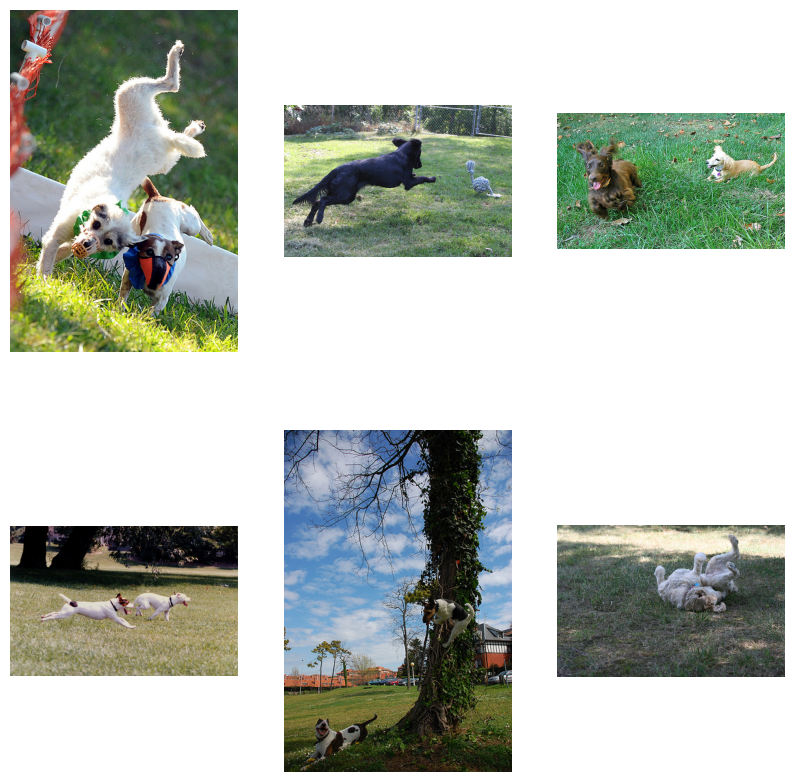

In [19]:
find_matches(model, 
             image_embeddings,
             query="dogs sitting on the grass",
             image_filenames=valid_df['image'].values,
             n=6)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


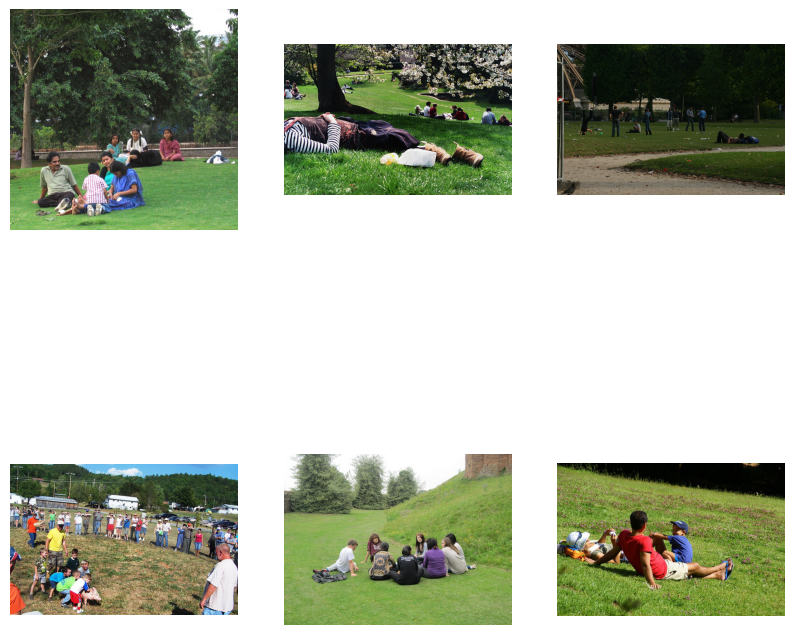

In [20]:
find_matches(model, 
             image_embeddings,
             query="people sitting on the grass",
             image_filenames=valid_df['image'].values,
             n=6)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


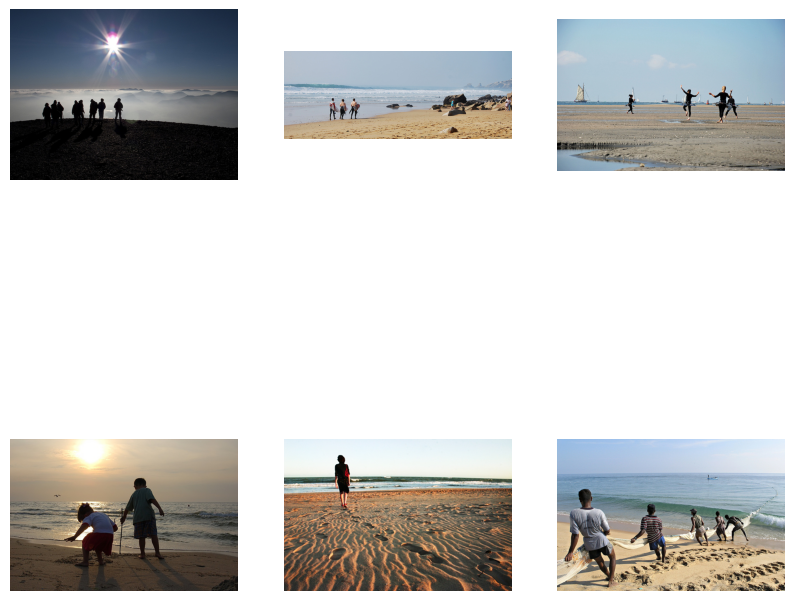

In [21]:
find_matches(model, 
             image_embeddings,
             query="people walking on the beach",
             image_filenames=valid_df['image'].values,
             n=6)